In [17]:
%matplotlib inline


"""
The data set in this example represents 1059 songs from various countries obtained 
from the UCI Machine Learning library. Various features of the audio tracks have been 
extracted, and each track has been tagged with the latitude and longitude of the capital
city of its country of origin. 

We'll treat this as a classification problem, and attempt to train a model to predict 
the country of origin of each model. 

Data source did not specifify what the audio features specifically are, just
    "In the 'default_features_1059_tracks.txt' file, the first 68 columns are audio 
    features of the track, and the last two columns are the origin of the music, 
    represented by latitude and longitude. 

    In the 'default_plus_chromatic_features_1059_tracks.txt' file, the first 116 
    columns are audio features of the track, and the last two columns are the 
    origin of the music."
"""

import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
import sys

#First get the data. The UCI ML Library distributes it as a zipped file;
#download the data and extract the two provided files to the 'data' folder before continuing
music_df = pd.read_csv('data\default_plus_chromatic_features_1059_tracks.txt', header=None)
music = music_df.as_matrix()


#Our features are all but the last two columns
X = music[:,0:-2]

#Since feature names were not given, we'll just assign strings with an incrementing integer
names = np.linspace(start=1, stop=116, num=116, dtype='int').tolist()
for idx, name in enumerate(names):
    names[idx] = "Feature " + str(name)


#The source data said that each song as tied to the capital city of it's origin country via a lat/lon pair. 
#Let's treat this as a multi-class classification problem. 
#Rather than reverse-geocoding, we'll just make a string out of the unique lat/lon pairs
lats = ["%.2f" % lat for lat in music_df[116]]
lons = ["%.2f" % lon for lon in music_df[117]]
song_latlons = []
for index, value in enumerate(lats):
    city_id = lats[index] + "," + lons[index]
    song_latlons.append(city_id)

unique_latlons = unique_labels(song_latlons)
city_options = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','AA','AB','AC','AD','AE','AF','AG']
city_name_map = {}
for idx,latlon in enumerate(unique_latlons):
    city_name_map[latlon] = city_options[idx]

ylist = []
for latlon in song_latlons:
    ylist.append(city_name_map[latlon])
y = np.array(ylist)

In [18]:
#We want yellowbrick to import from this repository, and assume this notebook is in repofolder/examples/subfolder/
sys.path.append("../../")
import yellowbrick as yb
from yellowbrick.features.rankd import Rank2D 
from yellowbrick.features.radviz import RadViz 
from yellowbrick.features.pcoords import ParallelCoordinates 

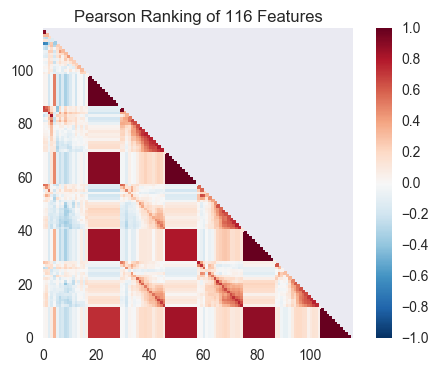

In [19]:
#See how well correlated the features are
visualizer = Rank2D(features = names, algorithm = 'pearson')
visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

In [20]:
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ClassificationReport


In [21]:
def train_and_classification_report(model):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state=11)
    
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    print("prec: {}".format(metrics.precision_score(y_true = y_test, y_pred = y_predict, average="weighted")))
    print("rec: {}".format(metrics.recall_score(y_true= y_test, y_pred = y_predict, average = "weighted")))

    cr_viz = ClassificationReport(model) #,classes=city_options
    cr_viz.fit(X_train, y_train)
    cr_viz.score(X_test, y_test)
    cr_viz.show()
    


prec: 0.430726301383904
rec: 0.4056603773584906


C:\Users\humph\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\humph\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


IndexError: list index out of range

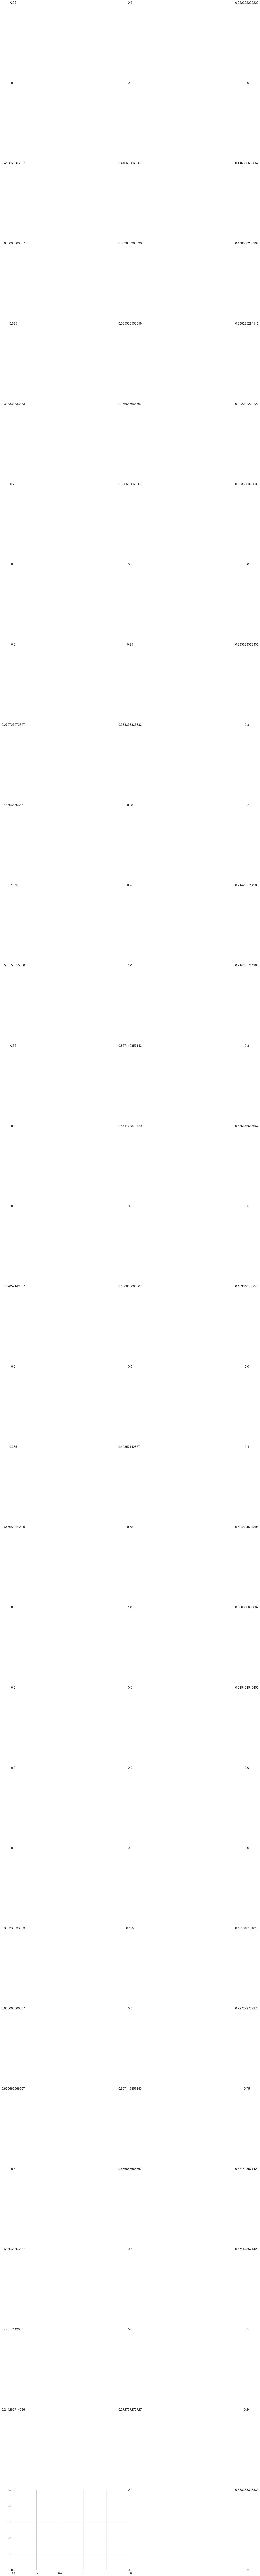

In [34]:
#Adding the reloading functionality so we can edit the source code and see results here. 
import importlib
importlib.reload(yb.classifier)
from yellowbrick.classifier import ClassificationReport

#This produces an IndexError: list index out of range. 
train_and_classification_report(LogisticRegression())

In [35]:
#This demonstrates a version of the Seaborn confusion matrix heatmap we could replicate (and improve on). 
def train_and_confusion_matrix(model):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state=11)
    
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    print("prec: {}".format(metrics.precision_score(y_true = y_test, y_pred = y_predict, average="weighted")))
    print("rec: {}".format(metrics.recall_score(y_true= y_test, y_pred = y_predict, average = "weighted")))

    c_matrix = confusion_matrix(y_true = y_test, y_pred = y_predict)
    
    sns.heatmap(c_matrix, square=True, annot=True, cbar=False, xticklabels=city_options, yticklabels = city_options)
    plt.xlabel('predicted value')
    plt.ylabel('true value')

prec: 0.430726301383904
rec: 0.4056603773584906


C:\Users\humph\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


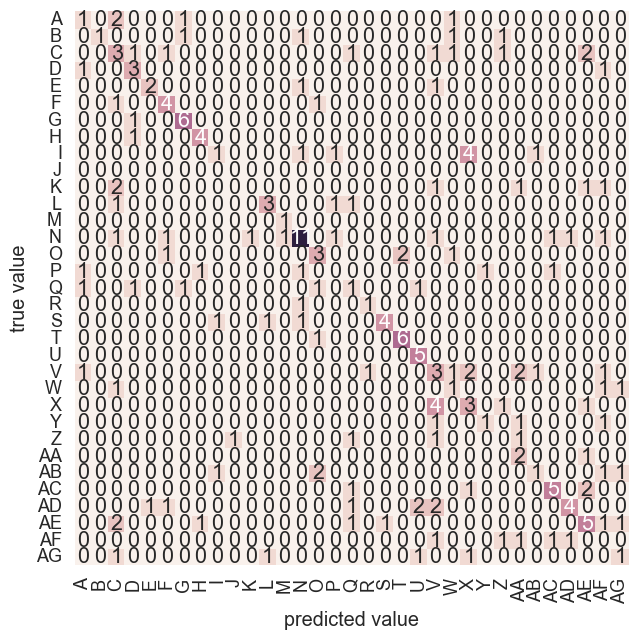

In [36]:
train_and_confusion_matrix(LogisticRegression())

In [37]:
def train_and_class_balance(model):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state=11)
    
    class_balance = yb.classifier.ClassBalance(model, classes=city_options)
    class_balance.fit(X_train, y_train)
    class_balance.score(X_test, y_test)
    class_balance.show()

C:\Users\humph\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


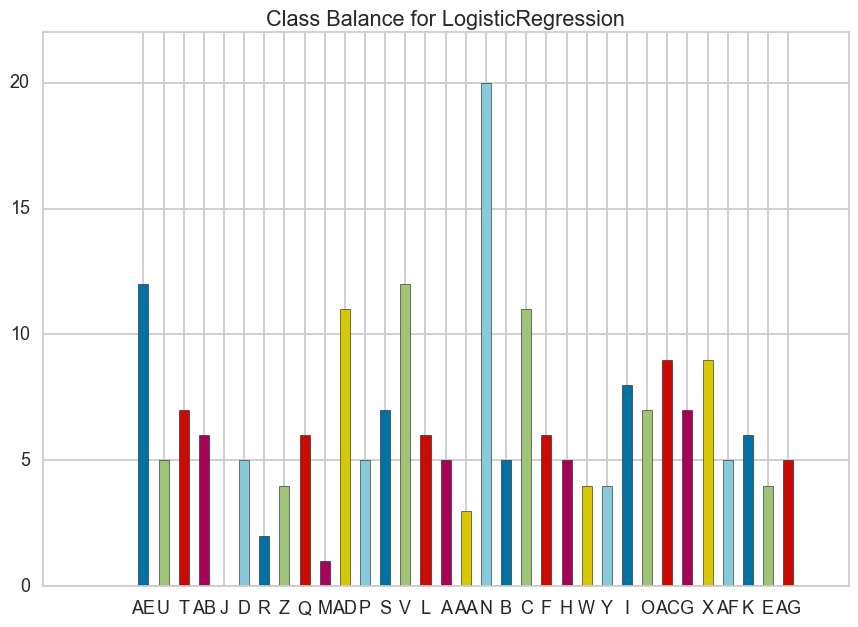

In [38]:
train_and_class_balance(LogisticRegression())